In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler
import cv2


cudnn.benchmark = True
plt.ion()


In [2]:
!ls

data.zip  sample_data


In [3]:
!unzip data.zip
%ls

Archive:  data.zip
   creating: data/
   creating: data/normal/
  inflating: data/normal/1.jpg       
  inflating: data/normal/10.jpg      
  inflating: data/normal/11.jpg      
  inflating: data/normal/12.png      
  inflating: data/normal/13.png      
  inflating: data/normal/14.jpg      
  inflating: data/normal/15.jpg      
  inflating: data/normal/16.jpg      
  inflating: data/normal/17.jpg      
  inflating: data/normal/18.jpg      
  inflating: data/normal/19.jpg      
  inflating: data/normal/2.jpg       
  inflating: data/normal/20.jpg      
  inflating: data/normal/21.jpg      
  inflating: data/normal/22.jpg      
  inflating: data/normal/23.jpg      
  inflating: data/normal/24.jpg      
  inflating: data/normal/25.jpg      
  inflating: data/normal/26.jpg      
  inflating: data/normal/27.jpg      
  inflating: data/normal/28.jpg      
  inflating: data/normal/29.jpg      
  inflating: data/normal/3.jpg       
  inflating: data/normal/34.jpg      
  inflating: data/normal

In [4]:
class ImageDataset(Dataset):
    def __init__(self, dataset_dir, train=False):
        self.data_transforms = {
                            'train': transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((256, 256)),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
                            'val': transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((256, 256)),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
                        }
        self.dataset_dir = dataset_dir

        self.labels = []
        self.raw_images = []
        self.train = train

        for dirpath, dirnames, filenames in os.walk(dataset_dir):
            for fn in filenames:
                label = 0 if 'normal' in dirpath else 1
                raw_img = cv2.imread(f'{dirpath}/{fn}')
                self.labels.append(label)
                self.raw_images.append(raw_img)

        self.train_images = [self.data_transforms['train'](img) for img in self.raw_images]
        self.test_images = [self.data_transforms['val'](img) for img in self.raw_images]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if self.train:
            return self.train_images[idx], self.labels[idx]
        else:
            return self.test_images[idx], self.labels[idx]

In [5]:
data_dir = 'data/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
n_images = 0
for dirpath, dirnames, filenames in os.walk(data_dir):
    n_images += len(filenames)

In [7]:
n_images

89

In [8]:
image_idxs = np.arange(n_images)

In [9]:

dataset = ImageDataset(data_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [10]:
from sklearn.model_selection import StratifiedKFold

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=47)

In [11]:
class_names = {0: 'normal', 1: 'phishing'}

In [12]:
device

device(type='cuda', index=0)

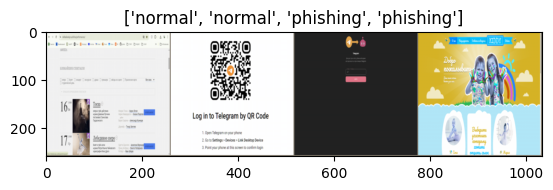

In [13]:

def imshow(inp, title=None):

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloader))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x.item()] for x in classes])

In [14]:
def train_cross_validation(num_epochs=25):
    since = time.time()
    sigm = nn.Sigmoid()

    train_losses_by_folds = [np.zeros(n_folds) for i in range(num_epochs)]
    val_losses_by_folds = [np.zeros(n_folds) for i in range(num_epochs)]
    train_accs_by_folds = [np.zeros(n_folds) for i in range(num_epochs)]
    val_accs_by_folds = [np.zeros(n_folds) for i in range(num_epochs)]

    best_model_params_path = os.path.join('.', 'best_model_params.pt')

    best_acc = 0.0

    for i, (train_index, test_index) in enumerate(skf.split(dataset.raw_images, dataset.labels)):
      print(f'\tFold: {i}/{n_folds}')
      print('\t' + '-' * 10)
      test_loader = DataLoader(dataset, batch_size=8, sampler=test_index)
      train_loader = DataLoader(dataset, batch_size=8, sampler=train_index)

      model = models.resnet152(weights='IMAGENET1K_V1')
      num_ftrs = model.fc.in_features
      model.fc = nn.Linear(num_ftrs, 1)
      # model.out = nn.Sigmoid(model.fc)

      model = model.to(device)

      criterion = nn.BCELoss()

      optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

      scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

      for epoch in range(num_epochs):
            print(f'Epoch: {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    loader = train_loader
                    model.train()
                else:
                    loader = test_loader
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in loader:
                    inputs = inputs.to(device)
                    labels = torch.unsqueeze(labels, 1).type('torch.FloatTensor').to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = sigm(model(inputs))
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()
                    fold_train_loss = running_loss / len(train_index)
                    fold_train_acc = running_corrects.double() / len(train_index)
                    train_losses_by_folds[epoch][i] = fold_train_loss
                    train_accs_by_folds[epoch][i] = fold_train_acc
                    print(f'\t\ttrain loss: {fold_train_loss}')
                    print(f'\t\ttrain acc: {fold_train_acc}')
                else:
                    fold_val_loss = running_loss / len(test_index)
                    fold_val_acc = running_corrects.double() / len(test_index)
                    val_losses_by_folds[epoch][i] = fold_val_loss
                    val_accs_by_folds[epoch][i] = fold_val_acc
                    print(f'\t\tval loss: {fold_val_loss}')
                    print(f'\t\tval acc: {fold_val_acc}')
                print()

            # mean validation loss
            if val_accs_by_folds[epoch].mean() > best_acc:
                best_acc = val_accs_by_folds[epoch].mean()
                torch.save(model.state_dict(), best_model_params_path)

      torch.save(model.state_dict(), best_model_params_path)
      break
    print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best mean val Acc: {best_acc:4f}')

    model.load_state_dict(torch.load(best_model_params_path))

    train_losses_by_folds = np.array(train_losses_by_folds)
    val_losses_by_folds = np.array(val_losses_by_folds)
    train_accs_by_folds = np.array(train_accs_by_folds)
    val_accs_by_folds = np.array(val_accs_by_folds)


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses_by_folds.mean(axis=1), label='Training Loss')
    plt.plot(val_losses_by_folds.mean(axis=1), label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs_by_folds.mean(axis=1), label='Training Accuracy')
    plt.plot(val_accs_by_folds.mean(axis=1), label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    return model




In [38]:
dataset = ImageDataset(data_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [39]:
model_ft = models.resnet152(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

	Fold: 0/5
	----------
Epoch: 0/49
----------
		train loss: 1.1414342547806215
		train acc: 4.507042253521127

		val loss: 0.7193051841523912
		val acc: 4.888888888888888

Epoch: 1/49
----------
		train loss: 0.8220855627261417
		train acc: 4.507042253521127

		val loss: 0.765389793448978
		val acc: 4.888888888888888

Epoch: 2/49
----------
		train loss: 1.0521977417905566
		train acc: 4.507042253521127

		val loss: 0.6519089937210083
		val acc: 4.888888888888888

Epoch: 3/49
----------
		train loss: 0.7594117455079522
		train acc: 4.507042253521127

		val loss: 0.689516544342041
		val acc: 4.888888888888888

Epoch: 4/49
----------
		train loss: 0.8971199082656646
		train acc: 4.507042253521127

		val loss: 0.6220996512307061
		val acc: 4.888888888888888

Epoch: 5/49
----------
		train loss: 0.7324946917278666
		train acc: 4.507042253521127

		val loss: 0.6316089232762655
		val acc: 4.888888888888888

Epoch: 6/49
----------
		train loss: 0.7742818736694228
		train acc: 4.50704225352112

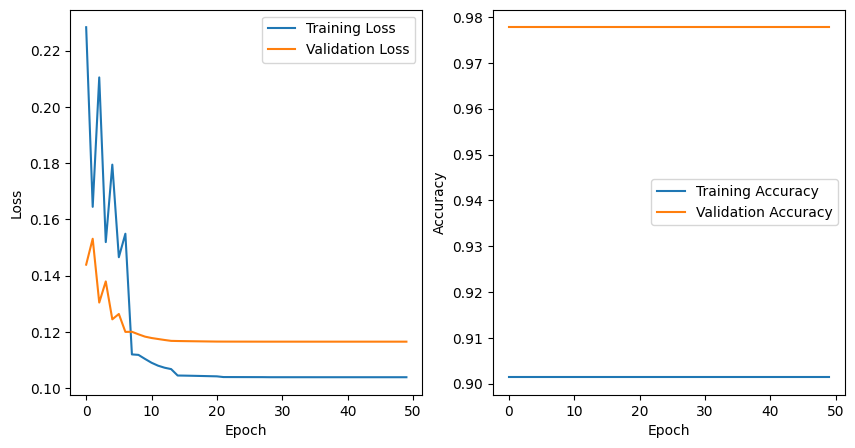

In [17]:
model_ft = train_cross_validation(num_epochs=50)

In [18]:
data = DataLoader(dataset, batch_size=8)
data.generator

In [19]:
# was_training = model.training
model_ft.eval()
# images_so_far = 0
# fig = plt.figure()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(DataLoader(dataset, batch_size=50)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        # _, preds = torch.max(outputs, 1)

        break

        #     for j in range(inputs.size()[0]):
        #         images_so_far += 1
        #         ax = plt.subplot(num_images//2, 2, images_so_far)
        #         ax.axis('off')
        #         ax.set_title(f'predicted: {class_names[preds[j]]}')
        #         imshow(inputs.cpu().data[j])

        #         if images_so_far == num_images:
        #             model.train(mode=was_training)
        #             return
        # model.train(mode=was_training)

In [20]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], device='cuda:0')

In [22]:
sigm = nn.Sigmoid()
sigm(outputs)

tensor([[0.3862],
        [0.3557],
        [0.3699],
        [0.4217],
        [0.3935],
        [0.4073],
        [0.4477],
        [0.4331],
        [0.3493],
        [0.3335],
        [0.4026],
        [0.4500],
        [0.3843],
        [0.3790],
        [0.4430],
        [0.3620],
        [0.4090],
        [0.3794],
        [0.3718],
        [0.4500],
        [0.3653],
        [0.4081],
        [0.3436],
        [0.4184],
        [0.3428],
        [0.3334],
        [0.3408],
        [0.4366],
        [0.3610],
        [0.3807],
        [0.3554],
        [0.4048],
        [0.3613],
        [0.3728],
        [0.4271],
        [0.4366],
        [0.4285],
        [0.4017],
        [0.3710],
        [0.4141],
        [0.3992],
        [0.3411],
        [0.3861],
        [0.3316],
        [0.3362],
        [0.4110],
        [0.3618],
        [0.3252],
        [0.3443],
        [0.3687]], device='cuda:0')

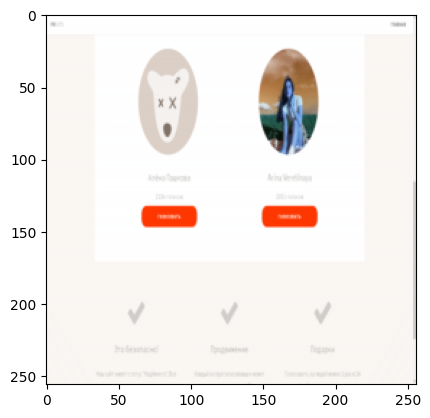

Predicted: normal, True: phishing


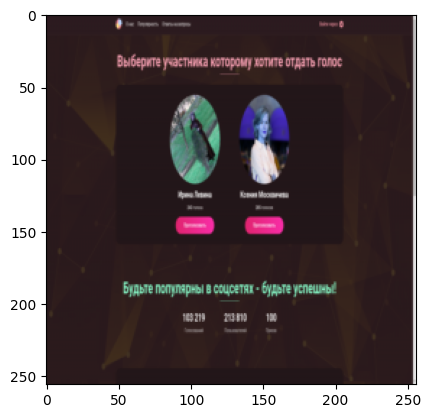

Predicted: normal, True: phishing


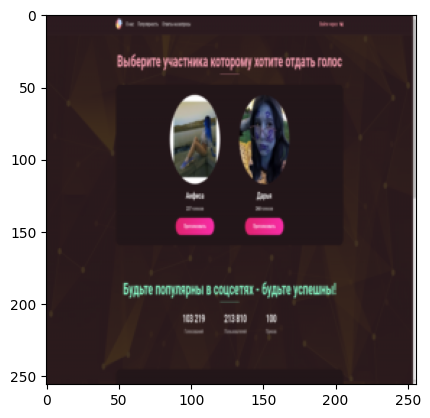

Predicted: normal, True: phishing


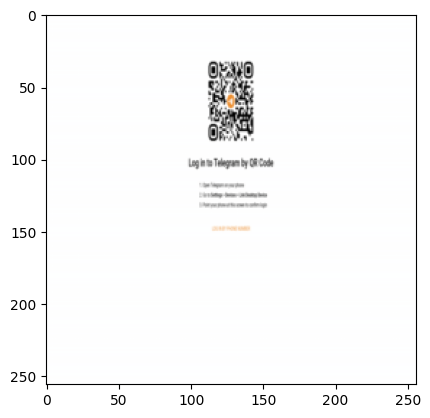

Predicted: normal, True: phishing


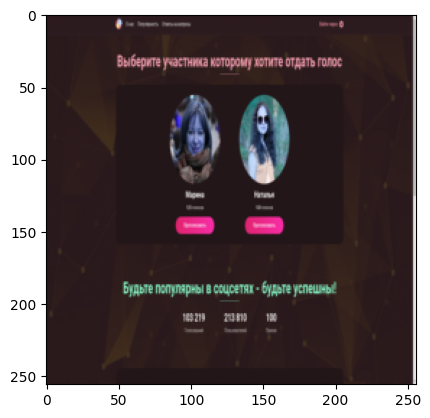

Predicted: normal, True: phishing


In [24]:
incorrect_predictions = []

with torch.no_grad():
    for inputs, labels in DataLoader(dataset, batch_size=50):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        incorrect_mask = preds != labels
        incorrect_indices = torch.nonzero(incorrect_mask).squeeze()

        for idx in incorrect_indices:
            incorrect_predictions.append((inputs[idx], preds[idx], labels[idx]))

num_samples_to_show = 5
for i in range(min(num_samples_to_show, len(incorrect_predictions))):
    input_image, predicted_label, true_label = incorrect_predictions[i]
    imshow(input_image.cpu().data)
    print(f'Predicted: {class_names[predicted_label.item()]}, True: {class_names[true_label.item()]}')


In [25]:
sigm = nn.Sigmoid()
model = models.resnet152(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model = model.to(device)
out = sigm(model(inputs))
print(out.shape)


torch.Size([39, 1])


In [26]:
criterion = nn.BCELoss()
criterion(out, torch.unsqueeze(labels, 1).type('torch.FloatTensor').to(device))

tensor(0.8199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [27]:
m = nn.Sigmoid()

In [28]:
labels

tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [29]:
preds

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [30]:
m(outputs)

tensor([[0.3584],
        [0.4600],
        [0.4444],
        [0.4851],
        [0.4850],
        [0.4505],
        [0.4888],
        [0.4285],
        [0.4556],
        [0.4051],
        [0.4309],
        [0.4933],
        [0.3897],
        [0.3987],
        [0.5005],
        [0.4793],
        [0.4627],
        [0.4958],
        [0.4783],
        [0.5687],
        [0.4685],
        [0.4822],
        [0.5175],
        [0.5062],
        [0.4588],
        [0.4163],
        [0.4326],
        [0.4929],
        [0.4593],
        [0.4719],
        [0.4558],
        [0.5093],
        [0.4557],
        [0.4473],
        [0.4745],
        [0.5236],
        [0.4556],
        [0.5080],
        [0.4719]], device='cuda:0')

In [32]:
#visualize_model(model_ft)

In [33]:
model_conv = torchvision.models.resnet152(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

	Fold: 0/5
	----------
Epoch: 0/24
----------
		train loss: 1.3033445804891453
		train acc: 4.507042253521127

		val loss: 0.6488169034322103
		val acc: 4.888888888888888

Epoch: 1/24
----------
		train loss: 0.7139961190626655
		train acc: 4.507042253521127

		val loss: 0.7598023811976115
		val acc: 4.888888888888888

Epoch: 2/24
----------
		train loss: 1.1292091624837526
		train acc: 4.507042253521127

		val loss: 0.586282836066352
		val acc: 4.888888888888888

Epoch: 3/24
----------
		train loss: 0.7284909117389733
		train acc: 4.507042253521127

		val loss: 0.6689287854565514
		val acc: 4.888888888888888

Epoch: 4/24
----------
		train loss: 0.9198822840838365
		train acc: 4.507042253521127

		val loss: 0.5631493859820895
		val acc: 4.888888888888888

Epoch: 5/24
----------
		train loss: 0.7168928468731087
		train acc: 4.507042253521127

		val loss: 0.5820887486139933
		val acc: 4.888888888888888

Epoch: 6/24
----------
		train loss: 0.7657033062317002
		train acc: 4.5070422535211

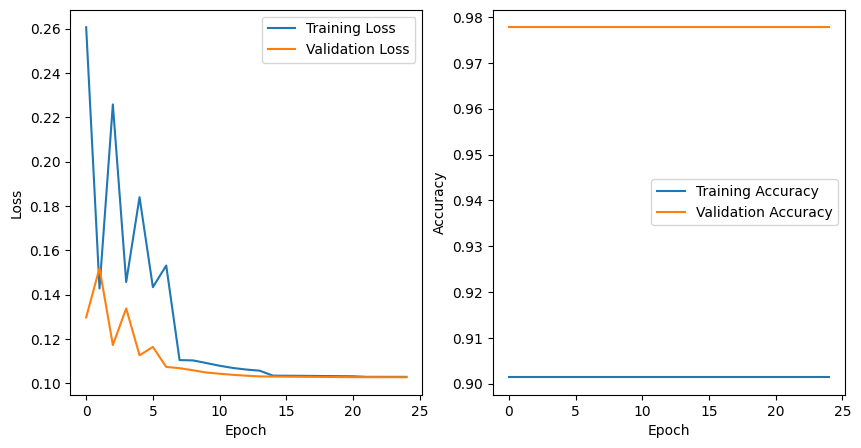

In [36]:
model_conv = train_cross_validation(num_epochs=25)

KeyError: tensor(0, device='cuda:0')

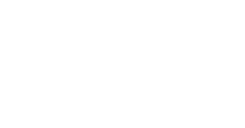

In [40]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='/content/data/train/normal/1.jpg'
)

plt.ioff()
plt.show()
